In [1]:
import numpy as np
import pandas as pd

import os
import math
import time
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [2]:
df_news = pd.read_excel("/content/news_share_data.xlsx")
df_news.head()

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,7014291,It's Time for a YouTube Competitor,It was reported last week that Yahoo is gettin...,2014-03-31,0.640816,5,3,1,4.579592,5,...,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.25,0.25,1600
1,7014327,The Ultimate Roundup of 2014's Biggest April F...,April Fools' marks the day when pranking goes ...,2014-04-01,0.549618,4,1,0,4.636704,7,...,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.00,0.00,1500
2,7014304,A Selfie and One Garish Jacket: How the Red So...,The 2013 World Series champion Boston Red Sox ...,2014-04-01,0.577236,8,1,0,4.627451,7,...,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.00,0.00,1400
3,7031995,African Telecom Proposes More Diverse Emoticons,Less than a week after Apple pledged to make i...,2014-04-01,0.525896,4,1,0,5.083665,9,...,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.00,0.00,1300
4,6541359,"Google to Launch Improved Android Camera App, ...",Android users may soon see a series of new fea...,2014-04-01,0.588889,6,9,0,4.336022,7,...,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.00,0.00,3000


In [3]:
df_news.columns

Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [4]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   article_id                  1003 non-null   int64         
 1   title                       1003 non-null   object        
 2   text                        1003 non-null   object        
 3   published_date              1003 non-null   datetime64[ns]
 4   unique_tokens_rate          1003 non-null   float64       
 5   num_hrefs                   1003 non-null   int64         
 6   num_imgs                    1003 non-null   int64         
 7   num_videos                  1003 non-null   int64         
 8   average_token_length        1003 non-null   float64       
 9   num_keywords                1003 non-null   int64         
 10  data_channel                1003 non-null   object        
 11  min_avg_key                 1003 non-null   float64     

In [5]:
df_news.shape

(1003, 22)

In [6]:
df_news.isnull().sum()

article_id                    0
title                         0
text                          0
published_date                0
unique_tokens_rate            0
num_hrefs                     0
num_imgs                      0
num_videos                    0
average_token_length          0
num_keywords                  0
data_channel                  0
min_avg_key                   0
max_avg_key                   0
avg_avg_key                   0
href_avg_shares               0
global_subjectivity           0
global_sentiment_polarity     0
global_rate_positive_words    0
global_rate_negative_words    0
title_subjectivity            0
title_sentiment_polarity      0
shares                        0
dtype: int64

In [7]:
df_news = df_news[df_news['title'].apply(lambda x: len(x.split())>4)]
print("Total number of articles after removal of title with short title:", df_news.shape[0])

Total number of articles after removal of title with short title: 1000


In [8]:
df_news.shape

(1000, 22)

Summary Statistics of Shares:


,shares
count,1000.000000
mean,4243.046000
std,22641.282639
min,58.000000
25%,1000.000000
50%,1600.000000
75%,3100.000000
max,663600.000000


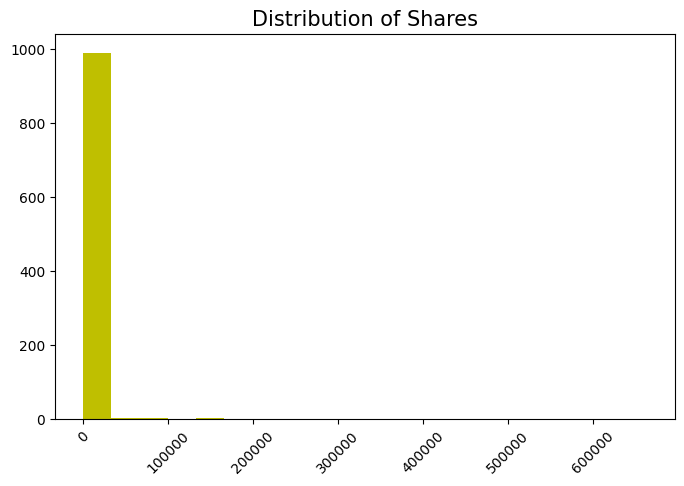

In [9]:
print("Summary Statistics of Shares:")
display(df_news[['shares']].describe())

plt.figure(figsize=(8,5))
plt.hist(df_news['shares'],bins=20, color = 'y')
plt.title("Distribution of Shares",size=15)
plt.xticks(rotation=45)
plt.show()

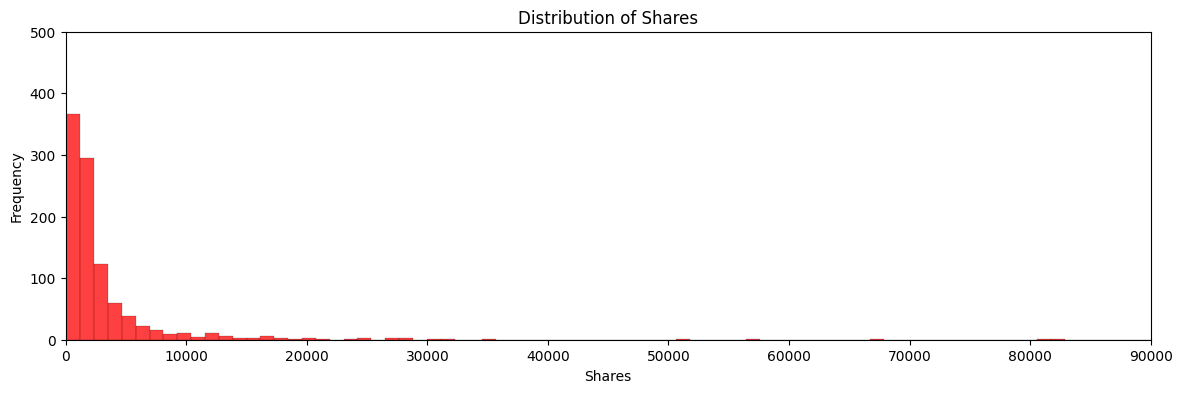

In [10]:
# Distribution of shares
array_shares = df_news['shares']

plt.figure(figsize=(14,4))
sns.histplot(array_shares, color = 'r', bins= 577, cbar= True)
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Distribution of Shares')
plt.xlim(0, 90000)  # Set the y-axis limit
plt.ylim(0, 500)  # Set the y-axis limit
plt.show()


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Text preprocessing

In [19]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r"'\s+", " ", text)
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    cleaned_text = ' '.join(tokens)
    return cleaned_text

df_news['cleaned_text'] = df_news['text'].apply(preprocess_text)
df_news['cleaned_title'] = df_news['title'].apply(preprocess_text)


In [20]:
df_news['cleaned_text'] .loc[15]

'april fools joke theres comedy cable network pocket youll happy see blurring lines tvs mobile devices comedy central launched allnew app tuesday offer generous helping flagship content free talking full episodes clips extras smartphones tablets seealso slugipadappsfree existing separate apps daily show jon stewart colbert report mostly offered snippets secondscreen goodies scuttled effective immediately good reason networks entire latenight lineup includes chris hardwicks midnight offered app nextday viewing recent season south park tv moving tablet website idea bigger app network steve grimes svp multiplatform programming strategy told mashable demo rollout though much frontfacing content free paytv subscribers log get full range comedy centrals onair programming plus bonuses notably entire season chapelles show content adsupported axe peace corona extra signed initial sponsors though youll appreciate show stars playing immediately theres preroll sponsor ads go commercials otherwise 

In [21]:
df_news['cleaned_title'].loc[15]

'new comedy central app bonanza full episodes free'

In [16]:
#for weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_news['weekday'] = df_news['published_date'].apply(lambda x: pd.to_datetime(x).day_name())

#for weekend
weekend_names = ['Friday', 'Saturday']

# Creating a binary indicator for the weekend
df_news['is_weekend'] = df_news['weekday'].apply(lambda x: 1 if x in weekend_names else 0)

# Extracting month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_news['month'] = df_news['published_date'].apply(lambda x: month_names[pd.to_datetime(x).month - 1])

df_news.sample(n=5)

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares,weekday,is_weekend,month
613,7027242,Time-Lapse Breaks Down the 'SNL' Studio in 2 M...,Part of the beauty of Saturday Night Live is t...,2014-04-10,0.429787,4,1,1,4.494217,7,...,0.449319,0.088376,0.041009,0.021030,0.60,-0.30000,1500,Thursday,0,April
397,7009830,The Prank That Puts Your Fake Pregnancy Scare ...,A group of students at Aquinas College in Gran...,2014-04-07,0.595420,4,1,0,5.184906,8,...,0.400246,0.021447,0.030189,0.033962,0.60,-0.13333,3400,Monday,0,April
850,7024473,Now You Can Get Microsoft Office 365 for $6.99...,Microsoft began selling Office 365 Personal on...,2014-04-15,0.515924,13,10,0,4.481013,5,...,0.580909,0.337273,0.044304,0.000000,0.00,0.00000,743,Tuesday,0,April
260,7031366,Human Rights Groups Call for End to Surveillan...,A group of major human rights organizations ha...,2014-04-04,0.523973,43,1,0,4.712446,6,...,0.583701,0.075251,0.035408,0.033262,0.60,-0.30000,1300,Friday,1,April
230,7031763,Warren Buffett Is Bullish on Cats,It turns out the Oracle of Omaha doesn't just ...,2014-04-03,0.475073,8,6,0,4.575881,6,...,0.562193,0.185620,0.044715,0.010840,0.75,0.25000,964,Thursday,0,April


In [17]:
df_news['data_channel'].value_counts()

00000            350
Tech             196
Entertainment    185
Business         164
Social Media      55
Lifestyle         50
Name: data_channel, dtype: int64

In [18]:

color_scale = px.colors.sequential.Cividis

fig = go.Figure(
    [go.Bar(
        x=df_news["data_channel"].value_counts().index,
        y=df_news["shares"].value_counts().values,
        marker_color=color_scale
    )]
)

fig.update_layout(
    title={"text": 'Distribution of articles Data channel-wise', 'y': 0.9, 'x': 0.5,},
    xaxis_title="Data channel name",
    yaxis_title="Number of articles"
)

fig.update_layout(width=800, height=700)
fig.show()



In [ ]:
df_news['cleaned_data_channel'] = df_news['data_channel'].replace('00000', 'Others')
df_news['cleaned_data_channel'].value_counts()


cleaned_data_channel
Others           350
Tech             196
Entertainment    185
Business         164
Social Media      55
Lifestyle         50
Name: count, dtype: int64

In [ ]:
# Applying one-hot encoding to the 'data_channel' column
enc_cleaned_data_channel = df_news[['cleaned_data_channel']]
enc_cleaned_data_channel = pd.get_dummies(enc_cleaned_data_channel, prefix= 'Channel', drop_first= True)
enc_cleaned_data_channel = enc_cleaned_data_channel.astype(int)
enc_cleaned_data_channel.head()

,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,1,0,0


In [ ]:
#concatenating one-hot encoded data channel with main dataframe
df_news = pd.concat([df_news,enc_cleaned_data_channel], axis = 1)
df_news.sample(5)

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,cleaned_title,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech
636,7006964,Al Jazeera America Announces First Layoffs Sin...,Al Jazeera America has initiated its first rou...,2014-04-11,0.439453,8,1,0,5.248047,6,...,al jazeera america announces first layoffs sin...,Friday,1,April,Others,0,0,1,0,0
992,7023018,Firefighters Battle Boredom With Hose Hovercraft,The typical day of a firefighter includes the ...,2014-04-17,0.656977,2,0,1,4.242938,6,...,firefighters battle boredom hose hovercraft,Thursday,0,April,Entertainment,1,0,0,0,0
177,7030278,David Letterman's Top 10 Late Night Television...,David Letterman announced Thursday he would re...,2014-04-03,0.371487,12,16,3,4.578508,6,...,david lettermans top 10 late night television ...,Thursday,0,April,Entertainment,1,0,0,0,0
59,6802220,Grow the Bushy Beard You've Always Wanted,"ThinkGeek, the home of all things geeky that y...",2014-04-01,0.516667,14,12,0,4.729282,6,...,grow bushy beard youve always wanted,Tuesday,0,April,Others,0,0,1,0,0
347,7030359,Child's Portrait Puts a Face on Drone Strikes ...,A drone pilot can sit in a room thousands of m...,2014-04-07,0.614841,6,1,0,4.959044,6,...,childs portrait puts face drone strikes pakistan,Monday,0,April,Entertainment,1,0,0,0,0


In [ ]:
df_news.columns

Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'cleaned_text', 'cleaned_title',
       'weekday', 'is_weekend', 'month', 'cleaned_data_channel',
       'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others',
       'Channel_Social Media', 'Channel_Tech'],
      dtype='object')

In [ ]:
df_news_final = df_news.drop(columns = ['article_id', 'title', 'text', 'published_date','data_channel', ], axis=1)
desired_columns = ['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month', 'cleaned_data_channel','Channel_Entertainment', 'Channel_Lifestyle',
                   'Channel_Others', 'Channel_Social Media', 'Channel_Tech', 'unique_tokens_rate',
                   'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
                   'num_keywords', 'min_avg_key', 'max_avg_key', 'avg_avg_key',
                   'href_avg_shares', 'global_subjectivity', 'global_sentiment_polarity',
                   'global_rate_positive_words', 'global_rate_negative_words',
                   'title_subjectivity', 'title_sentiment_polarity', 'shares']


df_news_final = df_news[desired_columns].copy()

df_news_final.head()

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,...,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.25,0.25,1600
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,Tech,0,0,0,0,...,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.00,0.00,1500
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,Tech,0,0,0,0,...,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.00,0.00,1400
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,Tuesday,0,April,Tech,0,0,0,0,...,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.00,0.00,1300
4,google launch improved android camera app repo...,android users may soon see series new features...,Tuesday,0,April,Others,0,0,1,0,...,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.00,0.00,3000


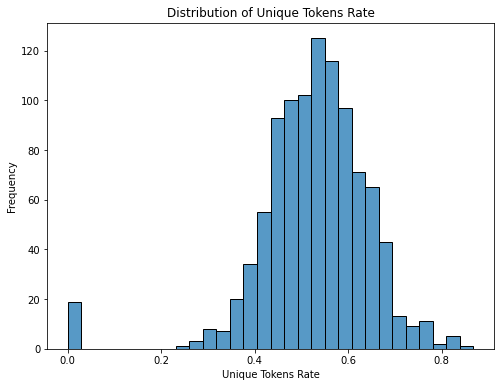

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_news['unique_tokens_rate'], bins=30)
plt.xlabel('Unique Tokens Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Tokens Rate')
plt.show()


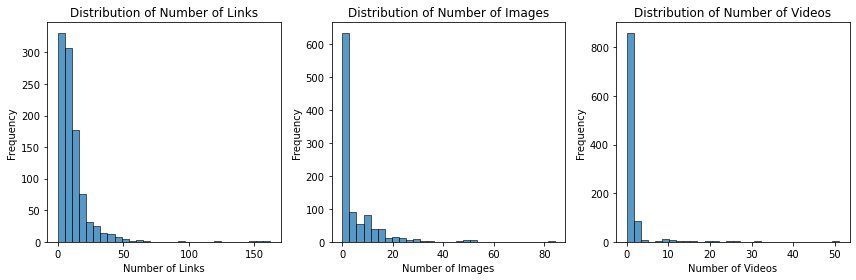

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(df_news['num_hrefs'], bins=30)
plt.xlabel('Number of Links')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Links')

plt.subplot(132)
sns.histplot(df_news['num_imgs'], bins=30)
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Images')

plt.subplot(133)
sns.histplot(df_news['num_videos'], bins=30)
plt.xlabel('Number of Videos')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Videos')

plt.tight_layout()
plt.show()


3. Average token length

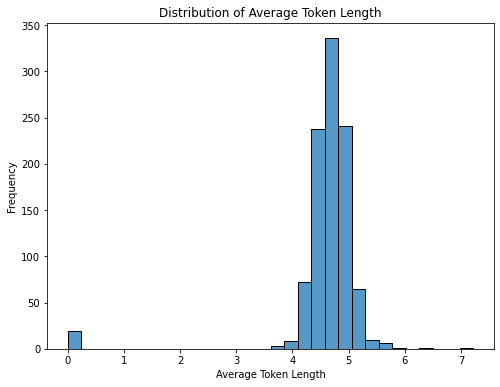

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_news['average_token_length'], bins=30)
plt.xlabel('Average Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Average Token Length')
plt.show()


4. Number of keywords

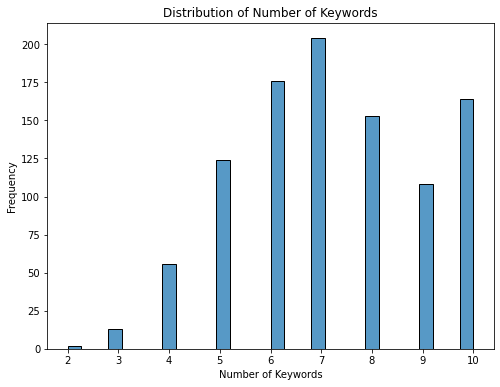

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_news['num_keywords'], bins=30)
plt.xlabel('Number of Keywords')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Keywords')
plt.show()

5. MIn, max and avg keys' distribution

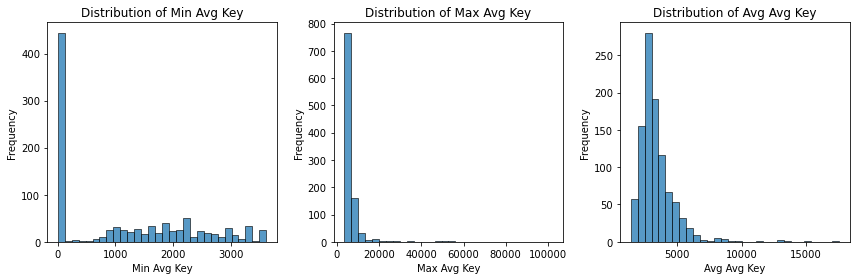

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(df_news['min_avg_key'], bins=30,)
plt.xlabel('Min Avg Key')
plt.ylabel('Frequency')
plt.title('Distribution of Min Avg Key')

plt.subplot(132)
sns.histplot(df_news['max_avg_key'], bins=30, )
plt.xlabel('Max Avg Key')
plt.ylabel('Frequency')
plt.title('Distribution of Max Avg Key')

plt.subplot(133)
sns.histplot(df_news['avg_avg_key'], bins=30,)
plt.xlabel('Avg Avg Key')
plt.ylabel('Frequency')
plt.title('Distribution of Avg Avg Key')

plt.tight_layout()
plt.show()


6. Data channel distributions by shares

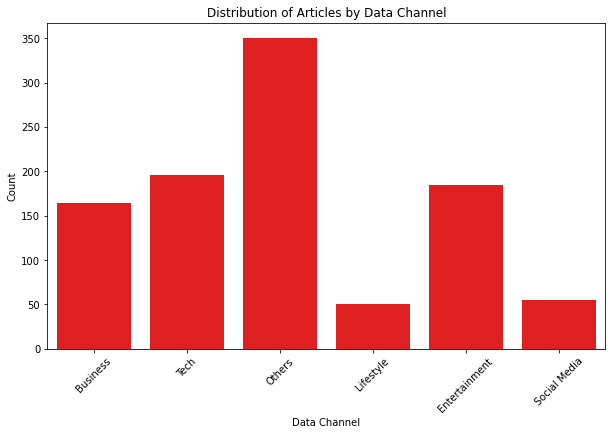

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_news, x='cleaned_data_channel', color = 'r')
plt.xlabel('Data Channel')
plt.ylabel('Count')
plt.title('Distribution of Articles by Data Channel')
plt.xticks(rotation=45)
plt.show()


7. other columns vs shares

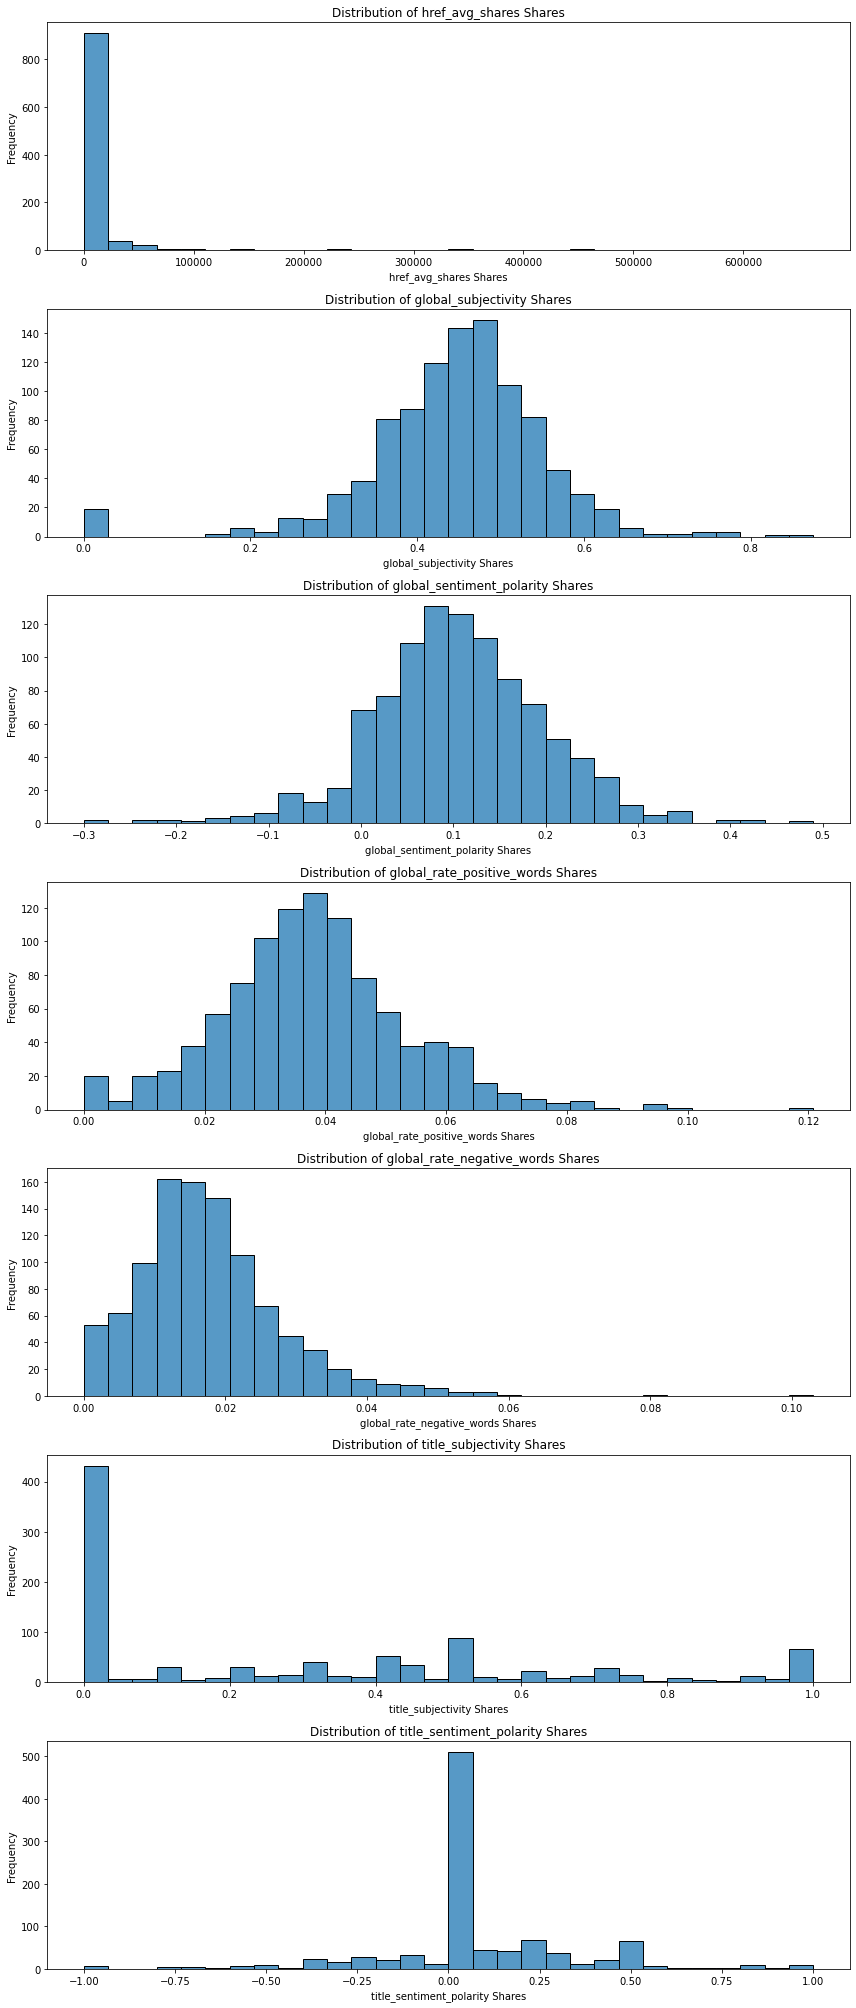

In [ ]:
columns_to_plot = ['href_avg_shares', 'global_subjectivity',                   'global_sentiment_polarity', 'global_rate_positive_words',
                   'global_rate_negative_words', 'title_subjectivity',
                   'title_sentiment_polarity']


fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 4 * len(columns_to_plot)))

for i, column_name in enumerate(columns_to_plot):
    sns.histplot(df_news[column_name], bins=30, ax=axes[i])
    axes[i].set_xlabel(f'{column_name} Shares')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {column_name} Shares')

plt.tight_layout()
plt.show()


In [ ]:
df_news_final.head(1)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,...,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.02449,0.25,0.25,1600


In [ ]:
df_news['month'].value_counts()

month
April    999
March      1
Name: count, dtype: int64

In [ ]:
'''from sklearn.preprocessing import LabelEncoder

#  label encoders for 'month' and 'weekday'
month_encoder = LabelEncoder()
weekday_encoder = LabelEncoder()

# Fit and transform the 'month' and 'weekday' columns
df_news_final['month number'] = month_encoder.fit_transform(df_news_final['month'])
df_news_final['weekday number'] = weekday_encoder.fit_transform(df_news_final['weekday'])
'''

"from sklearn.preprocessing import LabelEncoder\n\n#  label encoders for 'month' and 'weekday'\nmonth_encoder = LabelEncoder()\nweekday_encoder = LabelEncoder()\n\n# Fit and transform the 'month' and 'weekday' columns\ndf_news_final['month number'] = month_encoder.fit_transform(df_news_final['month'])\ndf_news_final['weekday number'] = weekday_encoder.fit_transform(df_news_final['weekday'])\n"

In [ ]:
df_news_final.columns

Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

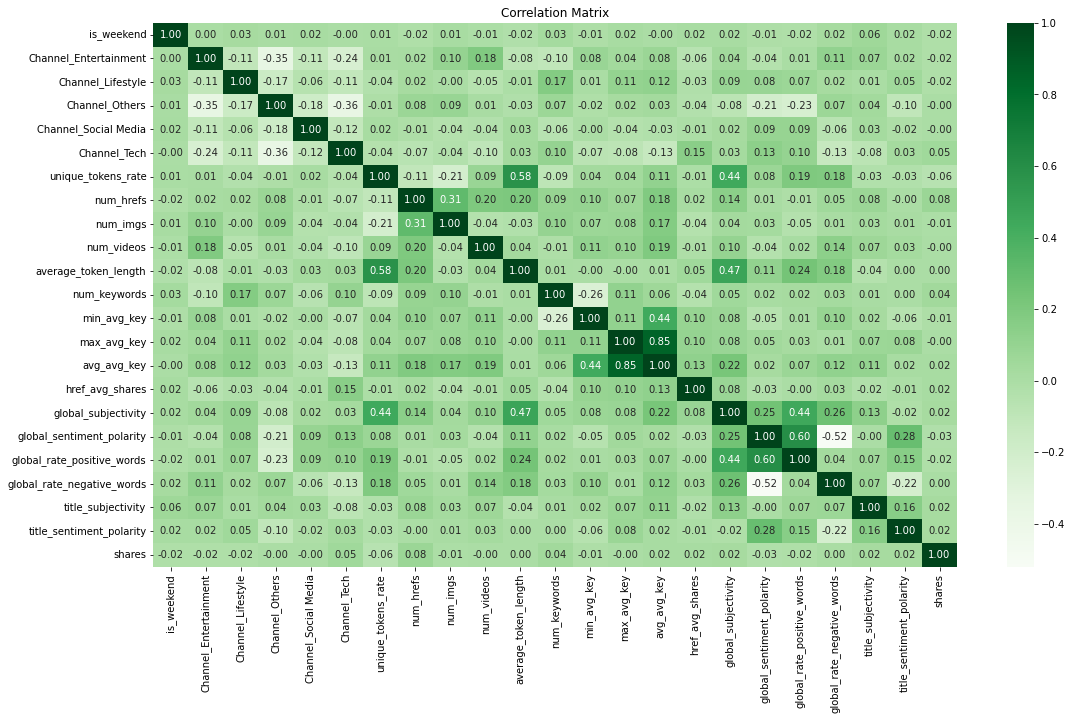

In [ ]:
num_news = df_news_final[['is_weekend',
       'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others',
       'Channel_Social Media', 'Channel_Tech', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'min_avg_key', 'max_avg_key', 'avg_avg_key',
       'href_avg_shares', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'title_subjectivity', 'title_sentiment_polarity', 'shares']]

correlation_matrix = num_news.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


2. **Box plots for categorical variables**


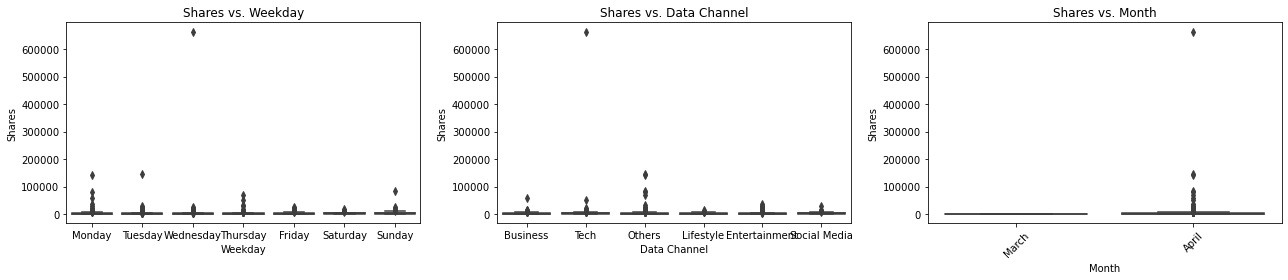

In [ ]:
plt.figure(figsize=(18, 4))

# Box plot for 'weekday'
plt.subplot(131)
sns.boxplot(x='weekday', y='shares', data=df_news, orient='v')
plt.xlabel('Weekday')
plt.ylabel('Shares')
plt.title('Shares vs. Weekday')

# Box plot for 'cleaned_data_channel'
plt.subplot(132)
sns.boxplot(x='cleaned_data_channel', y='shares', data=df_news, orient='v')
plt.xlabel('Data Channel')
plt.ylabel('Shares')
plt.title('Shares vs. Data Channel')

# Box plot for 'month'
plt.subplot(133)
sns.boxplot(x='month', y='shares', data=df_news, orient='v')
plt.xlabel('Month')
plt.ylabel('Shares')
plt.title('Shares vs. Month')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


3. Pair plots for numerical features

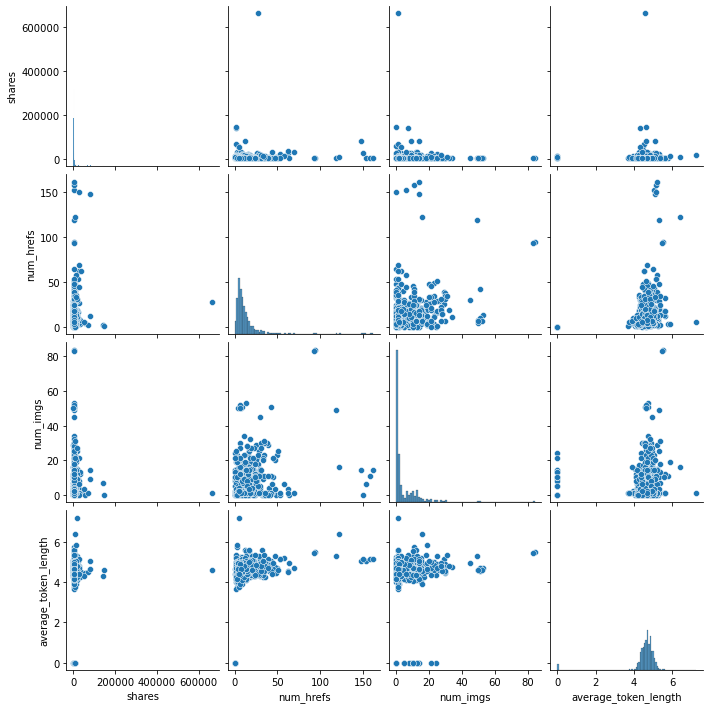

In [ ]:
# Pair plots for selected numerical features
sns.pairplot(df_news[['shares', 'num_hrefs', 'num_imgs', 'average_token_length']])
plt.show()



In [ ]:
df_news_final.columns

Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [ ]:
dc =   ['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month', 'cleaned_data_channel',
       'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others',
       'Channel_Social Media', 'Channel_Tech', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'min_avg_key', 'max_avg_key', 'avg_avg_key',
       'href_avg_shares', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'title_subjectivity', 'title_sentiment_polarity', 'shares',
       ]

df_news_final = df_news_final[dc].copy()

df_news_final.head()



,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,...,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.25,0.25,1600
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,Tech,0,0,0,0,...,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.00,0.00,1500
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,Tech,0,0,0,0,...,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.00,0.00,1400
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,Tuesday,0,April,Tech,0,0,0,0,...,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.00,0.00,1300
4,google launch improved android camera app repo...,android users may soon see series new features...,Tuesday,0,April,Others,0,0,1,0,...,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.00,0.00,3000


df_news_final.sample(5)

**A duplicate article_id was found that had two articles' info written and for that we should remove the ones that had less article shares**

In [ ]:

df_news['article_id_count'] = df_news.groupby('article_id')['article_id'].transform('count')

duplicate_articles = df_news[df_news['article_id_count'] > 1]

duplicate_articles

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,Wednesday,0,April,Lifestyle,0,1,0,0,0,2
511,7028680,"Dropbox Unveils Project Harmony, Mailbox for A...",Dropbox on Wednesday unveiled a suite of fresh...,2014-04-09,0.316504,42,11,0,4.540550,7,...,Wednesday,0,April,Business,0,0,0,0,0,2


**I dropped the row of 511 containing the same article_id from 510 with less shares**

In [ ]:
df_news_final = df_news.drop(511, axis=0)
df_news_final[510:513]

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,Wednesday,0,April,Lifestyle,0,1,0,0,0,2
512,7028664,Facebook's Not Messing Around: Messenger Will ...,When Facebook acquired standalone messaging ap...,2014-04-09,0.442667,38,30,1,4.902760,7,...,Wednesday,0,April,Others,0,0,1,0,0,1
513,7028589,Facebook Overhauls and Limits Those Despised R...,When Facebook rolled out its last desktop rede...,2014-04-09,0.608108,6,0,0,4.693694,6,...,Wednesday,0,April,Tech,0,0,0,0,1,1


In [ ]:
df_news_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 1002
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   article_id                  999 non-null    int64         
 1   title                       999 non-null    object        
 2   text                        999 non-null    object        
 3   published_date              999 non-null    datetime64[ns]
 4   unique_tokens_rate          999 non-null    float64       
 5   num_hrefs                   999 non-null    int64         
 6   num_imgs                    999 non-null    int64         
 7   num_videos                  999 non-null    int64         
 8   average_token_length        999 non-null    float64       
 9   num_keywords                999 non-null    int64         
 10  data_channel                999 non-null    object        
 11  min_avg_key                 999 non-null    float64       
 12

In [ ]:
df_news_final.columns


Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'cleaned_text', 'cleaned_title',
       'weekday', 'is_weekend', 'month', 'cleaned_data_channel',
       'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others',
       'Channel_Social Media', 'Channel_Tech', 'article_id_count'],
      dtype='object')

In [ ]:
df_news_final = df_news_final.drop(columns = ['article_id', 'title', 'text', 'published_date','article_id_count'])

In [ ]:

desired_columns = ['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month', 'cleaned_data_channel',
                   'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
                   'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
                    'min_avg_key', 'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
                   'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'title_subjectivity',
                   'title_sentiment_polarity', 'shares']

df_news_final = df_news_final[desired_columns]


In [ ]:
df_news_final

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,...,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.250000,0.250000,1600
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,Tech,0,0,0,0,...,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.000000,0.000000,1500
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,Tech,0,0,0,0,...,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.000000,0.000000,1400
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,Tuesday,0,April,Tech,0,0,0,0,...,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.000000,0.000000,1300
4,google launch improved android camera app repo...,android users may soon see series new features...,Tuesday,0,April,Others,0,0,1,0,...,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.000000,0.000000,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,make caesar salad 8 super specific apps,lets cut chase apps lot bells whistles theres ...,Thursday,0,April,Business,0,0,0,0,...,5709.823,4020.608,1950.000,0.493519,-0.119440,0.005376,0.021505,0.000000,0.000000,1300
999,taylor swift surprised fan bridal shower,taylor swift bridal showers made pastels baked...,Thursday,0,April,Tech,0,0,0,0,...,4352.491,2358.572,4200.000,0.455042,0.191196,0.053731,0.011940,0.000000,0.000000,1100
1000,amazing spiderman 2 hosts first google hangout...,weve seen big movies throw big google hangouts...,Thursday,0,April,Entertainment,1,0,0,0,...,6060.771,3296.052,3400.000,0.522917,0.009809,0.025381,0.045685,0.600000,-0.600000,4400
1001,2 animators independently recreated pixar magic,pixar art directors robert kondo dice tsutsumi...,Thursday,0,April,Business,0,0,0,0,...,4763.083,2709.129,0.000,0.494445,0.144969,0.069903,0.020388,0.833333,0.433333,1900


In [ ]:

df_news_final.to_csv("data/news_share_data_selected.csv",index=False)